### AUTOENCODER


##### Importing libraries


In [2]:
import keras
from keras import Sequential, layers
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

C:\Users\souha\AppData\Local\Temp\ipykernel_12320\11543658.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


##### importing the data 

In [3]:
AE_Data = pd.read_pickle("my_preprocessed_data.pkl")

##### splitting the data 

In [4]:
train_size = int(len(AE_Data) * 0.8)
train_data = AE_Data[:train_size]
test_data = AE_Data[train_size:]

##### saving the data 

In [4]:
train_data.to_pickle("train_data.pkl")
test_data.to_pickle("test_data.pkl")

##### Normalizing the data 

In [7]:

scaler = MinMaxScaler()
train_data = pd.DataFrame(scaler.fit_transform(
    train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(
    test_data), columns=test_data.columns)

##### Building the model

In [8]:
input_dim = train_data.shape[1]
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=8, max_value=64, step=8),
                           activation='relu', input_dim=input_dim))
    model.add(layers.Dense(input_dim, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error')
    plot_model(model, show_shapes=True, to_file='singlechannel_with_attention.png')

    return model


##### Tuning the hyperparameters

In [9]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=6,
    directory='my_dir',
    project_name='autoencoder'
)
# EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_data,
    train_data,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)
best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]
print(best_hps.values)

Trial 6 Complete [00h 01m 56s]
val_loss: 0.0015483505558222532

Best val_loss So Far: 6.8955364440626e-07
Total elapsed time: 00h 25m 35s
INFO:tensorflow:Oracle triggered exit
{'units': 48, 'learning_rate': 0.001}


##### Runing the model

In [45]:
model = tuner.hypermodel.build(best_hps)
# EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
model.fit(
    train_data,
    train_data,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)
# Predicting the test data
reconstructed_data = model.predict(test_data)


Epoch 1/100
2046/2046 [==============================] - 4s 2ms/step - loss: 0.0128 - val_loss: 7.0657e-04
Epoch 2/100
2046/2046 [==============================] - 4s 2ms/step - loss: 3.0960e-04 - val_loss: 1.8960e-04
Epoch 3/100
2046/2046 [==============================] - 4s 2ms/step - loss: 1.3415e-04 - val_loss: 1.0878e-04
Epoch 4/100
2046/2046 [==============================] - 5s 2ms/step - loss: 8.1990e-05 - val_loss: 9.4499e-05
Epoch 5/100
2046/2046 [==============================] - 4s 2ms/step - loss: 6.2479e-05 - val_loss: 5.4771e-05
Epoch 6/100
2046/2046 [==============================] - 4s 2ms/step - loss: 4.2632e-05 - val_loss: 3.5105e-05
Epoch 7/100
2046/2046 [==============================] - 4s 2ms/step - loss: 3.1443e-05 - val_loss: 3.7055e-05
Epoch 8/100
2046/2046 [==============================] - 5s 2ms/step - loss: 2.5629e-05 - val_loss: 2.7190e-05
Epoch 9/100
2046/2046 [==============================] - 4s 2ms/step - loss: 2.2044e-05 - val_loss: 2.2279e-05
Epoch

##### Results

In [47]:
# Error calculation
mse = mean_squared_error(test_data, reconstructed_data)
mae = mean_absolute_error(test_data, reconstructed_data)
r2 = r2_score(test_data, reconstructed_data)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Anomaly detection
reconstruction_error = np.mean(np.abs(test_data - reconstructed_data), axis=1)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomalies = reconstruction_error[reconstruction_error > threshold]
num_anomalies = len(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Mean Squared Error: 2.8677618728132017e-06
Mean Absolute Error: 0.0009159228882296539
R^2 Score: 0.9229665071060323
Number of anomalies: 264


##### Visualizations

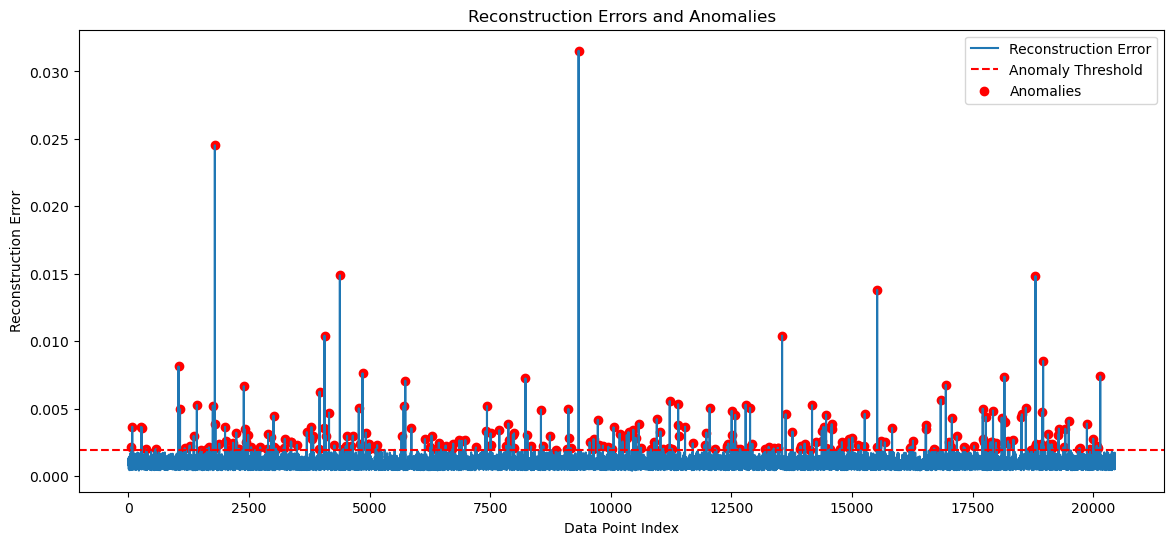

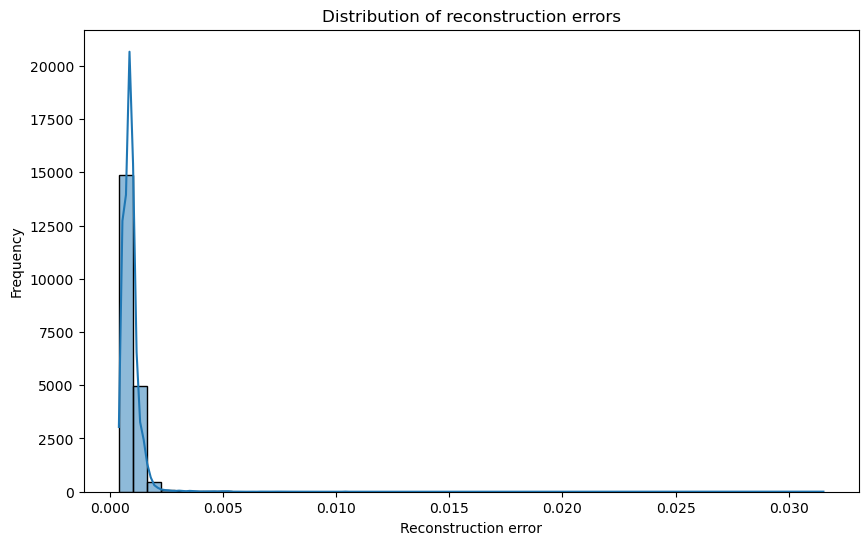

In [48]:

plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(np.where(reconstruction_error > threshold),
            anomalies, c='red', marker='o', label='Anomalies')
plt.legend()
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors and Anomalies')
plt.show()
test_data_np = np.array(test_data)
reconstructed_data_np = np.array(reconstructed_data)
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.title('Distribution of reconstruction errors')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.show()


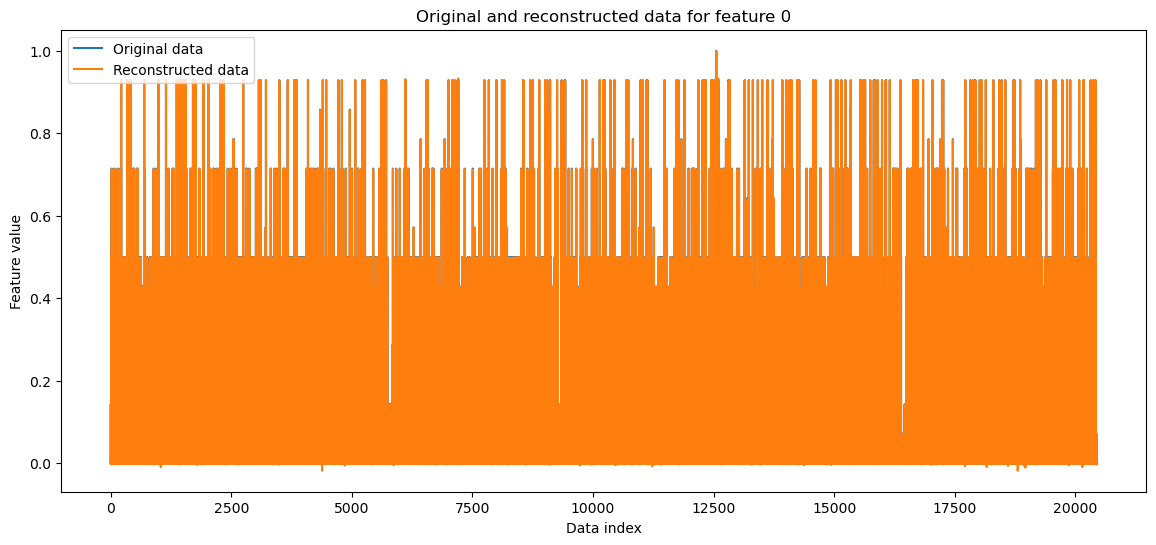

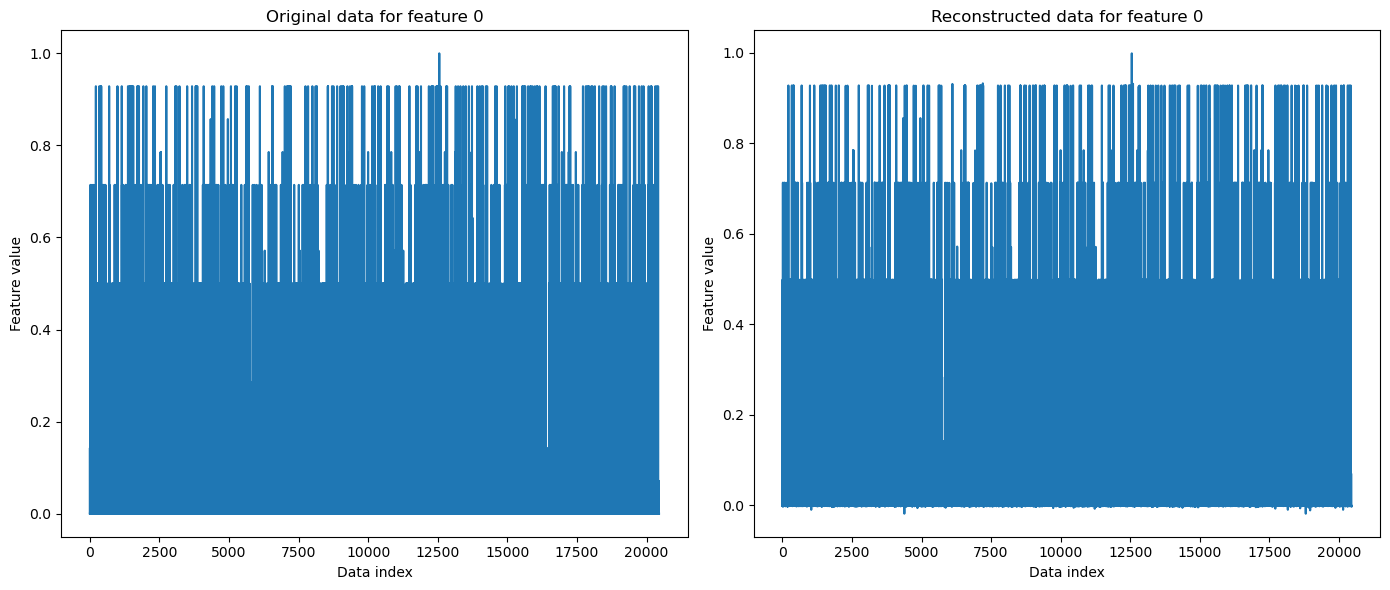

In [49]:
feature_idx = 8
plt.figure(figsize=(14, 6))
plt.plot(test_data_np[:, feature_idx], label='Original data')
plt.plot(reconstructed_data_np[:, feature_idx], label='Reconstructed data')
plt.title('Original and reconstructed data for feature 0')
plt.xlabel('Data index')
plt.ylabel('Feature value')
plt.legend()
plt.show()
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  
plt.plot(test_data_np[:, feature_idx], label='Original data')
plt.title('Original data for feature 0')
plt.xlabel('Data index')
plt.ylabel('Feature value')

plt.subplot(1, 2, 2)
plt.plot(reconstructed_data_np[:, feature_idx], label='Reconstructed data')
plt.title('Reconstructed data for feature 0')
plt.xlabel('Data index')
plt.ylabel('Feature value')

plt.tight_layout() 
plt.show()


##### Labeling Data

In [12]:
# Creating a DataFrame for labels
labels = pd.DataFrame(index=test_data.index)
labels['anomaly'] = (reconstruction_error > threshold).astype(int)

# adds the anomaly labels
labeled_data = test_data.copy()
labeled_data['anomaly'] = labels

##### Saving the labeled Data

In [13]:
labeled_data.to_pickle("my_labeled_data.pkl")